##  Multi-Contact dynamics for biped walking (Talos legs)
In this example, we describe the multi-contact dynamics through holonomic constraints for the support legs. From the Gauss principle, we have derived the model as:
$$
\left[\begin{matrix}
 \mathbf{M} & \mathbf{J}^{\top}_c \\
 {\mathbf{J}_{c}} & \mathbf{0} \\
\end{matrix}\right]
\left[\begin{matrix}
 \dot{\mathbf{v}} \\ -\boldsymbol{\lambda}
\end{matrix}\right]
 = 
\left[\begin{matrix}
  \boldsymbol{\tau} - \mathbf{h} \\
  -\dot{\mathbf{J}}_c \mathbf{v} \\
\end{matrix}\right]$$.


Base on a predefined walking gait, we build per each phase a specific multi-contact dynamics. Indeed we need to describe multi-phase optimal control problem. One can formulate the multi-contact optimal control problem (MCOP) as follows:


$$\mathbf{X}^*,\mathbf{U}^*=
\begin{Bmatrix} \mathbf{x}^*_0,\cdots,\mathbf{x}^*_N \\
				  \mathbf{u}^*_0,\cdots,\mathbf{u}^*_N
\end{Bmatrix} =
\arg\min_{\mathbf{X},\mathbf{U}} \sum_{p=0}^P \sum_{k=1}^{N(p)} \int_{t_k}^{t_k+\Delta t} l_p(\mathbf{x},\mathbf{u})dt$$
subject to
$$ \mathbf{\dot{x}} = \mathbf{f}_p(\mathbf{x},\mathbf{u}), \text{for } t \in [\tau_p,\tau_{p+1}]$$

$$ \mathbf{g}(\mathbf{v}^{p+1},\mathbf{v}^p) = \mathbf{0}$$

$$ \mathbf{x}\in\mathcal{X}_p, \mathbf{u}\in\mathcal{U}_p, \boldsymbol{\lambda}\in\mathcal{K}_p.$$

where $\mathbf{g}(\cdot,\cdot,\cdot)$ describes the contact dynamics, and they represents terminal constraints in each walking phase. In this example we use the following impact model:

$$\mathbf{M}(\mathbf{v}_{next}-\mathbf{v}) = \mathbf{J}_{impulse}^T$$

$$\mathbf{J}_{impulse} \mathbf{v}_{next} = \mathbf{0}$$

$$\mathbf{J}_{c} \mathbf{v}_{next} = \mathbf{J}_{c} \mathbf{v}$$

SimpleBipedGaitProblem class builds action models for each locomotion phase:
  - createSwingFootModel: defines an action model for the swing phase
  - createFootSwitchModel: defines an action model for switch knots between phases
  
Then we build a walking by combining a set of contact phases and their contact switches. This is defined by createFootstepModel

Now let's create a walking OC problem for the Talos legs.

In [1]:
import crocoddyl
import pinocchio
import numpy as np
import example_robot_data
from crocoddyl.utils.biped import SimpleBipedGaitProblem

crocoddyl.switchToNumpyMatrix()

# Creating the lower-body part of Talos
talos_legs = example_robot_data.loadTalosLegs()
""" lims = talos_legs.model.effortLimit
lims *= 0.5  # reduced artificially the torque limits
talos_legs.model.effortLimit = lims """

# Setting up the 3d walking problem
rightFoot = 'right_sole_link'
leftFoot = 'left_sole_link'

#Display the loaded robot model
display = crocoddyl.GepettoDisplay(talos_legs, 4, 4, frameNames=[rightFoot, leftFoot])

print(talos_legs.model.nq) # 19 [7Root, 6 Left, 6 Right]
print(talos_legs.model.nv)

19
18


In [2]:
gait = SimpleBipedGaitProblem(talos_legs.model, rightFoot, leftFoot)
display = crocoddyl.GepettoDisplay(talos_legs, 4, 4, frameNames=[rightFoot, leftFoot])
#print(len(gait.rmodel.defaultState))
#print(gait.rmodel.defaultState)




In [4]:
# Create the initial state
q0 = talos_legs.q0.copy()
#print(q0)
v0 = pinocchio.utils.zero(talos_legs.model.nv)
x0 = np.concatenate([q0,v0])


# Creating the walking problem
stepLength = 0.6 # meters
stepHeight = 0.1 # meters
timeStep = 0.0375 # seconds
stepKnots = 20
supportKnots = 10
problem = gait.createWalkingProblem(x0, stepLength, stepHeight, timeStep, stepKnots, supportKnots)


# Solving the 3d walking problem using Feasibility-prone DDP
ddp = crocoddyl.SolverFDDP(problem)
display = crocoddyl.GepettoDisplay(talos_legs, 4, 4, frameNames=[rightFoot, leftFoot])
cameraTF = [3., 3.68, 0.84, 0.2, 0.62, 0.72, 0.22]
ddp.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose(),
                  crocoddyl.CallbackDisplay(display)])
ddp.th_stop = 1e-9
init_xs = [talos_legs.model.defaultState] * (problem.T + 1)
init_us = []
maxiter = 1000
regInit = 0.1
ddp.solve(init_xs, init_us, maxiter, False, regInit)

True

With the following commands we can plot 
 - the state and control trajectories, and
 - the DDP performance

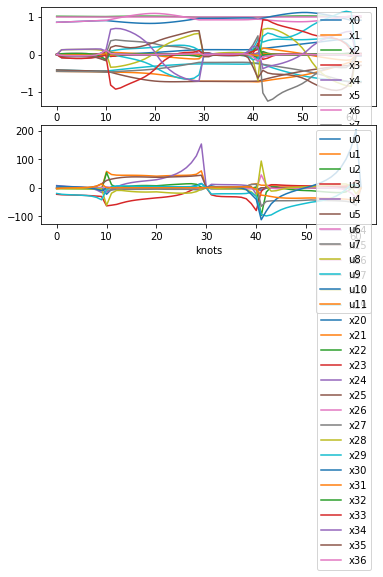

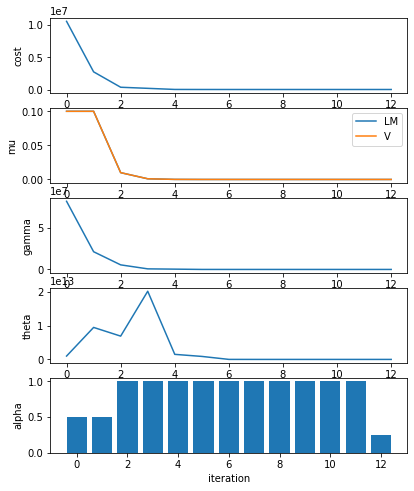

In [4]:
%matplotlib inline

# Plotting the solution and the DDP convergence
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps)


Finally we can visualize the solution using gepetto-viewer.

In [5]:
# Visualization of the DDP solution in gepetto-viewer
#rate = 2.
#display.displayFromSolver(ddp, rate)

display = crocoddyl.GepettoDisplay(talos_legs, frameNames=[rightFoot, leftFoot])
display.displayFromSolver(ddp)

## VI. Understanding the walking problem

In this problem we pre-defined a 20 and 10 knots for the step and double support phases with $dt=$3.75e-2, repectively. 

 1. Could you tell us how much is the foot step and double support duration?
 2. What happens when do we change $dt$ (e.g. 2e-2 secs)?
 3. What happens when do we change the number of step knots (e.g. 10)?
